In [33]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
from kneed import KneeLocator
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.75, random_state=2)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [75]:
pd.DataFrame(X, columns=feature_names).describe()

,x1,x2
count,300.000000,300.000000
mean,-2.920353,-3.233006
std,92.872732,101.251122
min,-188.394649,-251.957930
25%,-79.144230,-74.866120
50%,-15.527081,-6.890370
75%,69.936232,60.078319
max,332.353481,316.096597


In [3]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

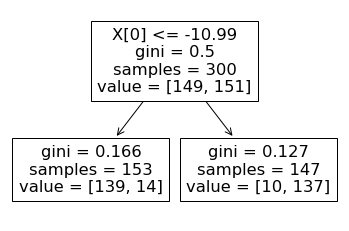

In [29]:
from sklearn.tree import plot_tree
plot_tree(tree);

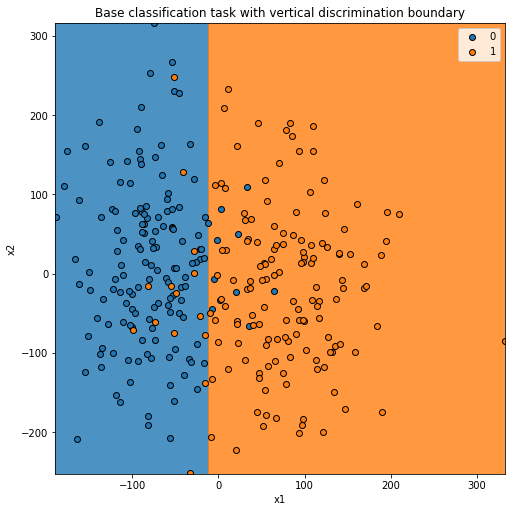

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with vertical discrimination boundary', feature_names,
                       predict=tree.predict, class_names=tree.classes_,
                       fig=fig, ax=ax)

In [5]:
clf_a = tree

In [6]:
from helper_models import ModifiedClassifier
class MyModifiedClassifier(ModifiedClassifier):
    def _preprocess(self, X):
        X2 = X.copy()
        X2[:, 0] += 25
        return X2
    
clf_b = MyModifiedClassifier(tree)
clf_b.fit(X, y)

MyModifiedClassifier(base_model=DecisionTreeClassifier(max_depth=1))

In [7]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

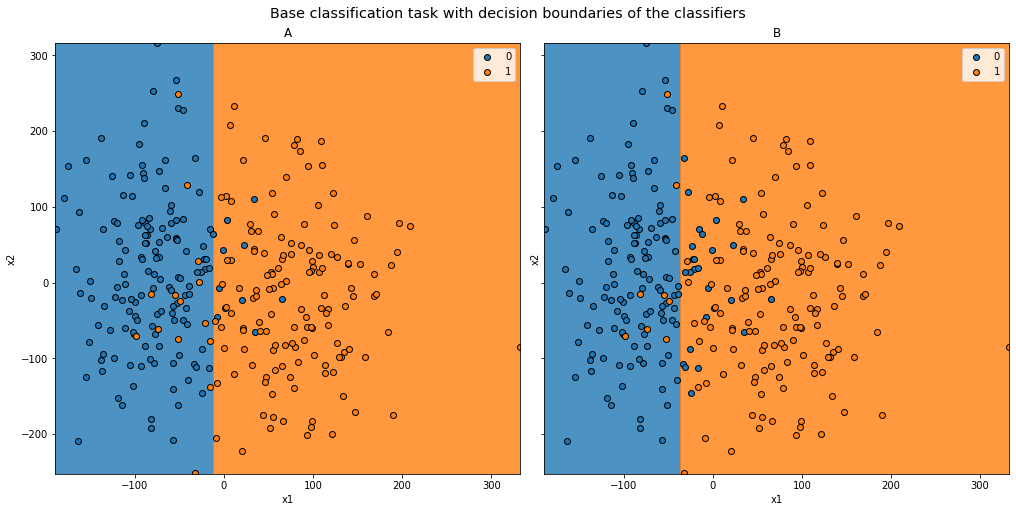

In [8]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

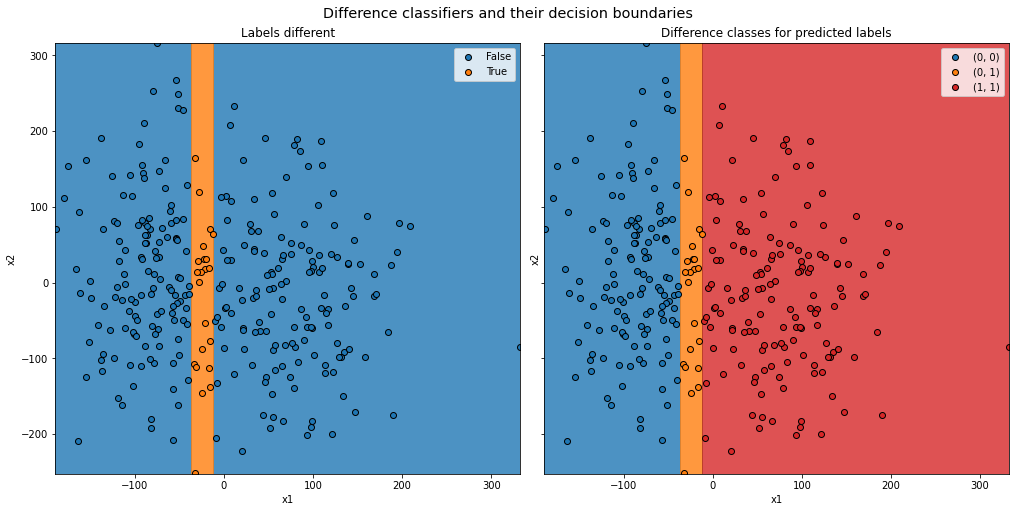

In [9]:
comparer.plot_decision_boundaries(X)

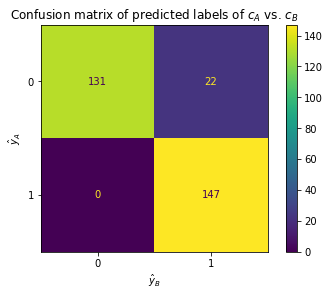

In [10]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [11]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 7.31 s, sys: 140 ms, total: 7.46 s
Wall time: 10.9 s


In [13]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 2), (0,), (0,))

In [12]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Both classifiers base their decisions on x1, its absolute importance is nearly equal.

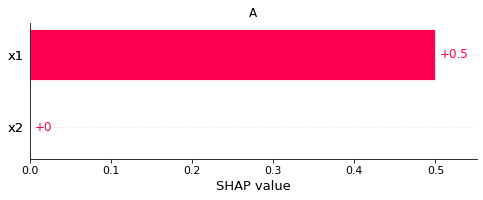

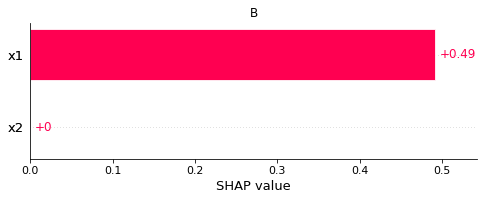

In [21]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [24]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [25]:
feature_order = feature_order[:1]

In [26]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.labels[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.labels[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

We clearly see, that low x1 values have a negative effect and high values a positive effect on the outcome of each classifier. But for B, the step from values negative effects to positive effects occurs earlier than for A, encompassing the instances highlighted in red, which are classified differently.

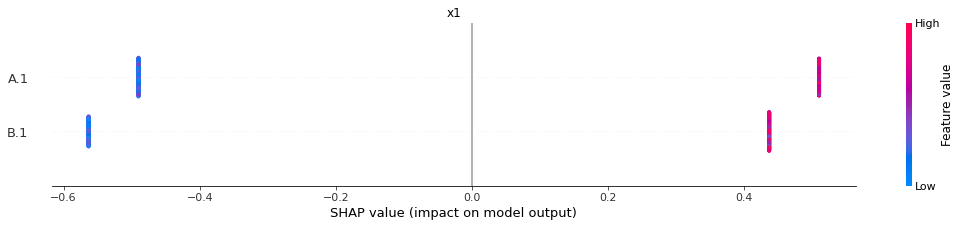

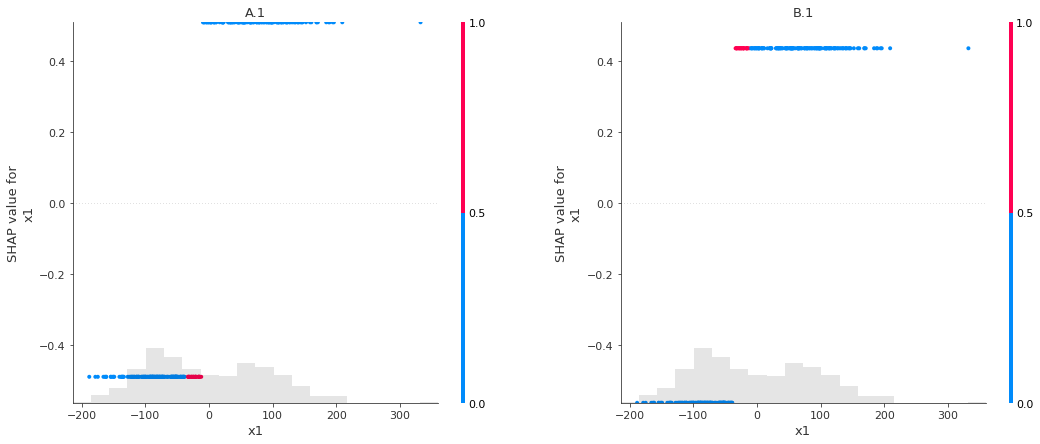

In [27]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

In the feature and class importance plots, we can see that class $(1,0)$ does not play any role. Neither does x2 play any role, so I skip them in the further analysis.

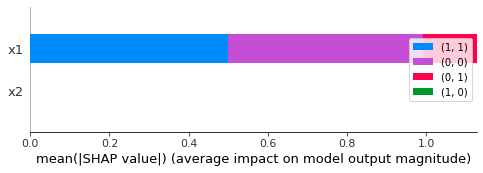

In [31]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

In [36]:
feature_order = feature_order[:-1]

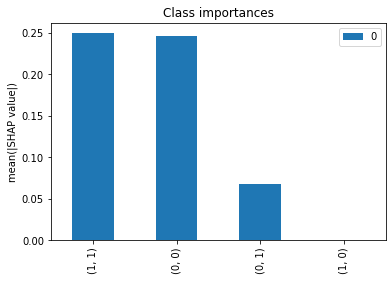

In [37]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [47]:
class_order = np.sort(class_order[:-1])

In [54]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order])
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order], color=is_pred_diff)
it = iter(feature_order)

We can see, that low x1 values increase the probability of $(0,0)$, high values increase the probability of $(1,1)$ and close to zero is a group of instances classified differently for which it increases the probability of $(0,1)$.

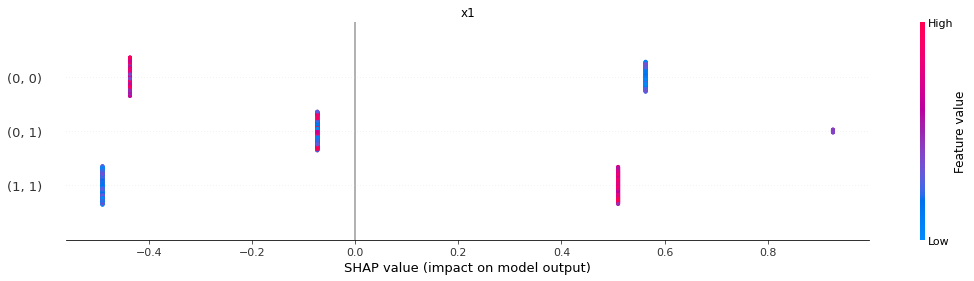

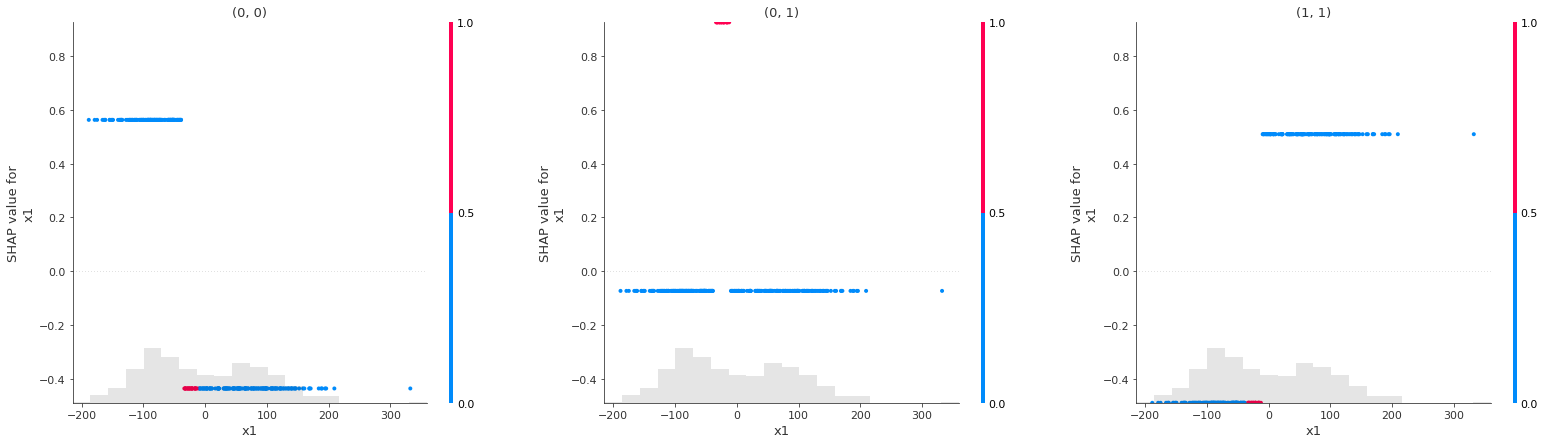

In [55]:
plot_next_feature()

# Local Explanations

In the dendrogram we can see, that at maximum three clusters are possible.

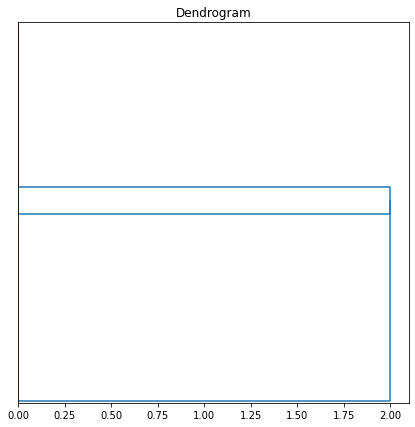

In [57]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

Up to $n=2$ all instances are put in the same cluster

In [61]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=2)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,131,22,0,147
c2,0,0,0,0


And from $n=3$ they are split across three clusters. So I will continue analyzing c2, which contains the instances classified differently.

In [63]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=4)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,0,147
c2,0,22,0,0
c3,131,0,0,0
c4,0,0,0,0


In [64]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=3)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,0,147
c2,0,22,0,0
c3,131,0,0,0


In [67]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

## 1. Cluster

These feature value distributions are different locally compared to the global level:
- x1 reaches only from -33 to -12
- x2 reaches only up to 164

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x1 was lower, the effect would shift towards $(0,0)$: Setting it to -100 changes all predictions to this class.
- if x1 was higher, the effect would shift towards $(1,1)$: Setting it to 0 changes all predictions to this class.

Locally, only constant effects are visible within the cluster.

In [68]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c2,0,22,0,0


In [69]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,22.000000,22.000000
mean,-23.607816,-20.967493
std,6.462889,98.491450
min,-33.604034,-251.957930
25%,-28.305512,-102.705281
50%,-23.985576,14.172903
75%,-17.893540,30.926609
max,-12.420569,164.191464


In [76]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,22.0
"(0, 1)",22.0,NaN


In [77]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",22.0,NaN
"(1, 1)",NaN,22.0


### SHAP-based Difference Classifier Explanations

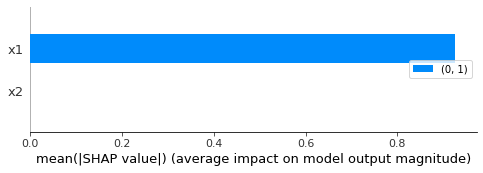

In [70]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

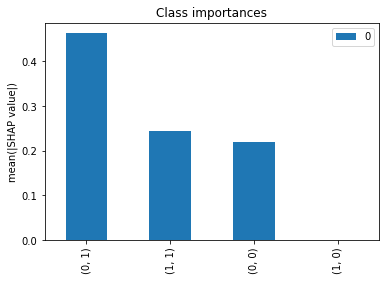

In [71]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [72]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

Within the cluster, there are only constant effects visible.

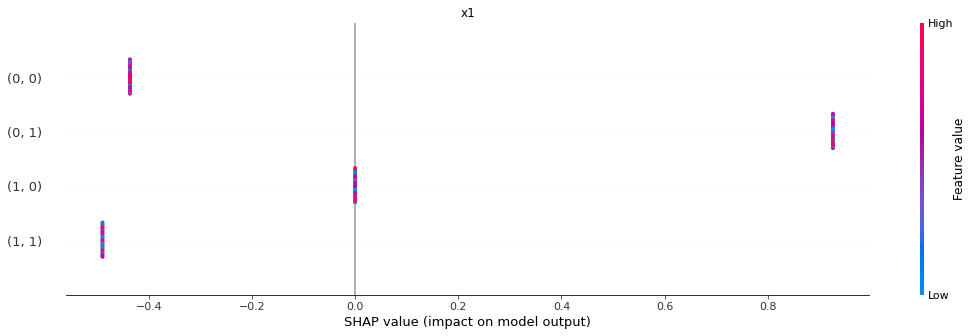

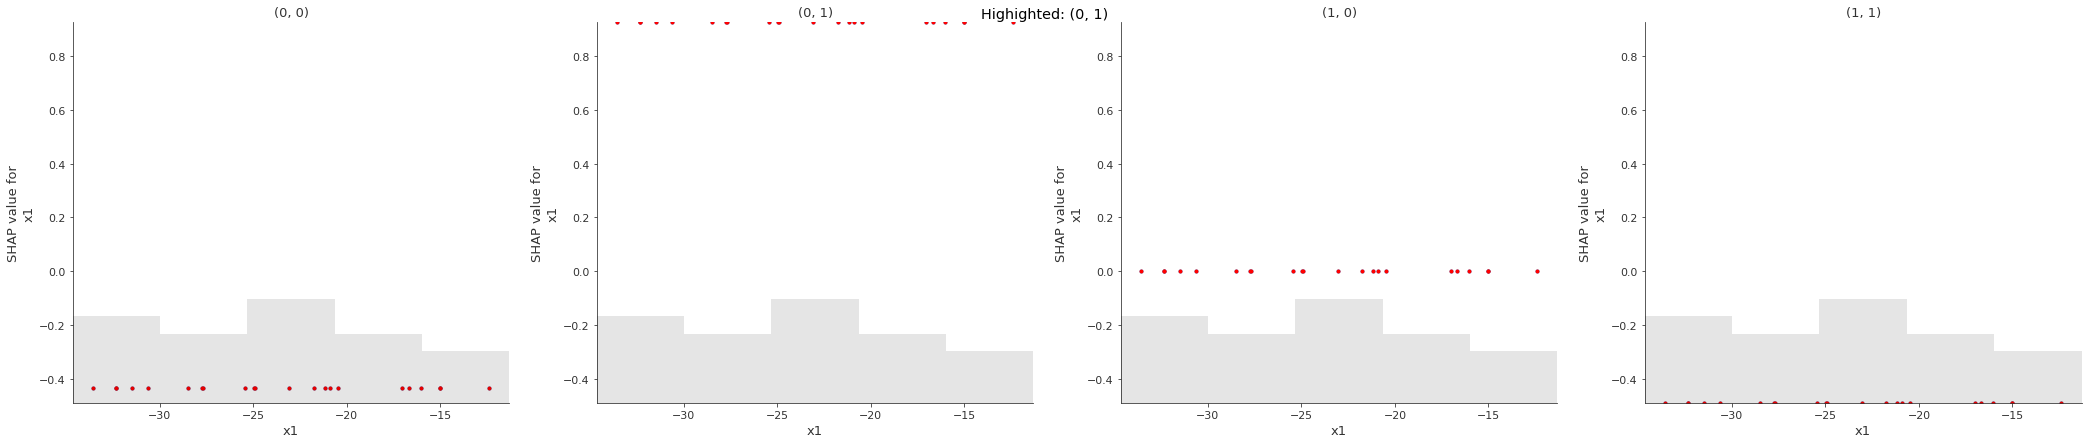

In [73]:
plot_next_feature()

### diro2c

The alternative local approach came to the same conclusion. It tells us that class $(0,1)$ is classified between x1 -35.5 and -10.5. Please note, that there are rounding issues that account for the differences to the actualy boundary.

In [78]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [80]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 15.1 s, sys: 105 ms, total: 15.2 s
Wall time: 15.4 s


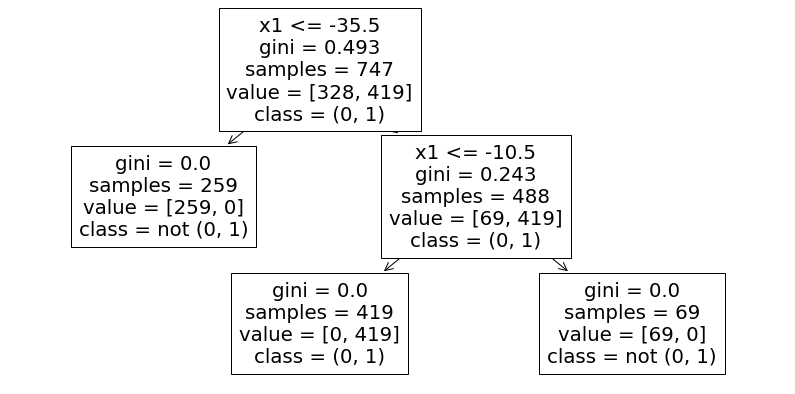

In [84]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation)

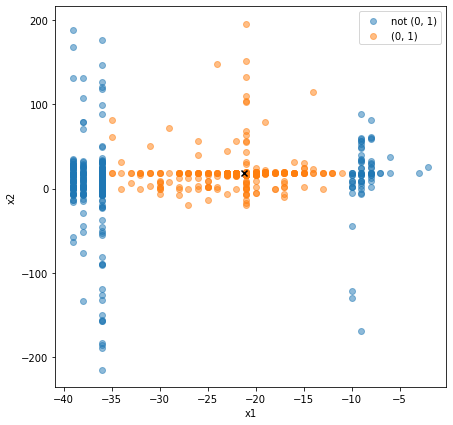

In [83]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)